## Settings for Google Colab

Please uncomment and run cell below if your are on Colab to set data and auxiliary files.

In [1]:
# %%capture
# !mkdir data
# !wget https://raw.githubusercontent.com/datacubeR/DeepAnt/master/data/TravelTime_451.csv -O data/TravelTime_451.csv
# !wget https://raw.githubusercontent.com/datacubeR/DeepAnt/master/data/DeepAnt.png -O data/DeepAnt.png
# !wget https://raw.githubusercontent.com/datacubeR/DeepAnt/master/deepant.py -O deepant.py
# !wget https://raw.githubusercontent.com/datacubeR/DeepAnt/master/utils.py -O utils.py
# !pip install pytorch-lightning
# !pip install torchinfo

## DeepAnt

In [2]:
import pandas as pd
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from torchinfo import summary

from deepant import AnomalyDetector, DataModule, TrafficDataset, DeepAnt

from utils import plot_predictions, loss_plot, ts_plot

pl.seed_everything(42, workers=True)


if not torch.cuda.is_available():
    print('Please Activate GPU Accelerator if available')
else:
    print('Everything is Set')


Global seed set to 42


Everything is Set


## Data Import

In order to implement DeepAnt I will use a dataset that is part of Numenta Benchmark that is used in the Paper as part of Model Validation. The dataset can be found in the same Repo. According to the name, the dataset contains Traveltime as a timeseries. 

The task is to find out what scores are anomaly.

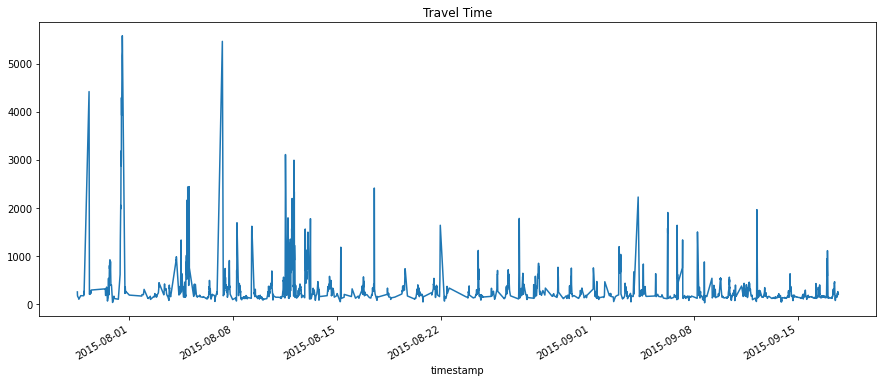

In [3]:
df = pd.read_csv('data/TravelTime_451.csv', index_col = 'timestamp', parse_dates=['timestamp'])
df.plot(figsize = (15, 6), title = 'Travel Time', legend = False);

## Model Training

In order to make the algorithm to work I will use Hyperparameters mentioned in the paper as much as possible. In case no values are provided, I will be hard coding those.

![](data/DeepAnt.png)

In this case, I will be using Sequence Length of 10, and Forecasting Horizon (P_w) 1. The Convolution Blocks use 32 filters, 3x3 Conv Kernel and 2x2 MaxPooling. Fully Connected Layer uses a 40 Units Hidden Layer before Ouptut.

The Model is Trained with MAE Loss (L1Loss in Pytorch) during 30 epochs.



In [4]:
SEQ_LEN = 10
dataset = TrafficDataset(df, SEQ_LEN)
target_idx = dataset.timestamp # Timestamps to detect where the Anomaly Happens
X, y = dataset[0]
X.shape, y.shape, len(dataset) # Checking Sizes are compatible...


(torch.Size([1, 10]), torch.Size([1]), 2152)

In [5]:
model = DeepAnt(SEQ_LEN, 1)
sample = torch.randn(32,1,10)

model(sample).shape

torch.Size([32, 1])

In [6]:
model = DeepAnt(SEQ_LEN, 1)
anomaly_detector = AnomalyDetector(model)
dm = DataModule(df, SEQ_LEN)
mc = ModelCheckpoint(
    dirpath = 'checkpoints',
    save_last = True,
    save_top_k = 1,
    verbose = True,
    monitor = 'train_loss', 
    mode = 'min'
    )

mc.CHECKPOINT_NAME_LAST = f'DeepAnt-best-checkpoint'
summary(model)

Layer (type:depth-idx)                   Param #
DeepAnt                                  --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       128
│    └─ReLU: 2-2                         --
│    └─MaxPool1d: 2-3                    --
├─Sequential: 1-2                        --
│    └─Conv1d: 2-4                       3,104
│    └─ReLU: 2-5                         --
│    └─MaxPool1d: 2-6                    --
├─Flatten: 1-3                           --
├─Sequential: 1-4                        --
│    └─Linear: 2-7                       1,320
│    └─ReLU: 2-8                         --
│    └─Dropout: 2-9                      --
├─Linear: 1-5                            41
Total params: 4,593
Trainable params: 4,593
Non-trainable params: 0

In [7]:
trainer = pl.Trainer(max_epochs=30,
                    accelerator="gpu",
                    devices=1, 
                    callbacks=[mc], 
                    #progress_bar_refresh_rate=30, 
                    #fast_dev_run=True,
                    #overfit_batches=1
                    )
trainer.fit(anomaly_detector, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/alfonso/miniconda3/envs/dl/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:608: UserWarning: Checkpoint directory /home/alfonso/Documents/deepant/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | model     | DeepAnt | 4.6 K 
1 | criterion | L1Loss  | 0     
--------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, global step 68: 'train_loss' reached 0.09627 (best 0.09627), saving model to '/home/alfonso/Documents/deepant/checkpoints/epoch=0-step=68.ckpt' as top 1
Epoch 1, global step 136: 'train_loss' reached 0.06732 (best 0.06732), saving model to '/home/alfonso/Documents/deepant/checkpoints/epoch=1-step=136.ckpt' as top 1
Epoch 2, global step 204: 'train_loss' was not in top 1
Epoch 3, global step 272: 'train_loss' reached 0.06699 (best 0.06699), saving model to '/home/alfonso/Documents/deepant/checkpoints/epoch=3-step=272.ckpt' as top 1
Epoch 4, global step 340: 'train_loss' reached 0.04623 (best 0.04623), saving model to '/home/alfonso/Documents/deepant/checkpoints/epoch=4-step=340.ckpt' as top 1
Epoch 5, global step 408: 'train_loss' was not in top 1
Epoch 6, global step 476: 'train_loss' was not in top 1
Epoch 7, global step 544: 'train_loss' was not in top 1
Epoch 8, global step 612: 'train_loss' was not in top 1
Epoch 9, global step 680: 'train_loss' was not in top 1
Epoch 10, 

In [8]:
anomaly_detector = AnomalyDetector.load_from_checkpoint('checkpoints/DeepAnt-best-checkpoint.ckpt',
                                model = model)

In [9]:
output = trainer.predict(anomaly_detector, dm)
preds_losses = pd.Series(torch.tensor([item[1] for item in output]).numpy(), index = target_idx)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 68it [00:00, ?it/s]

# Finding Threshold

After checking the Loss Distribution, the Threshold chose for detecting anomaly wat set to 0.5

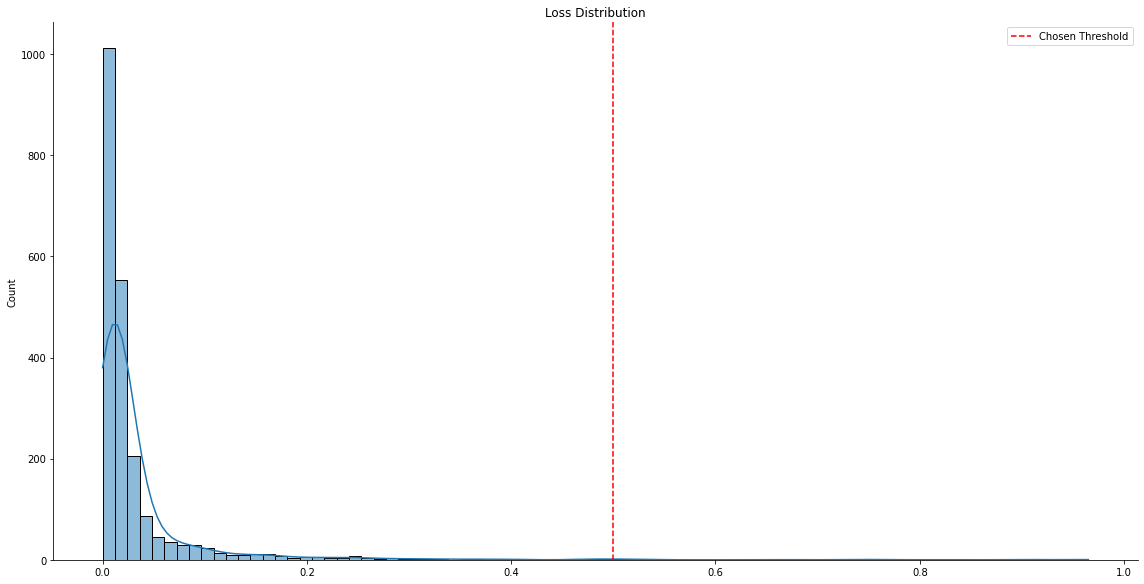

In [10]:
THRESHOLD = 0.5    
plot_predictions(preds_losses, THRESHOLD)

## Detected Anomalies

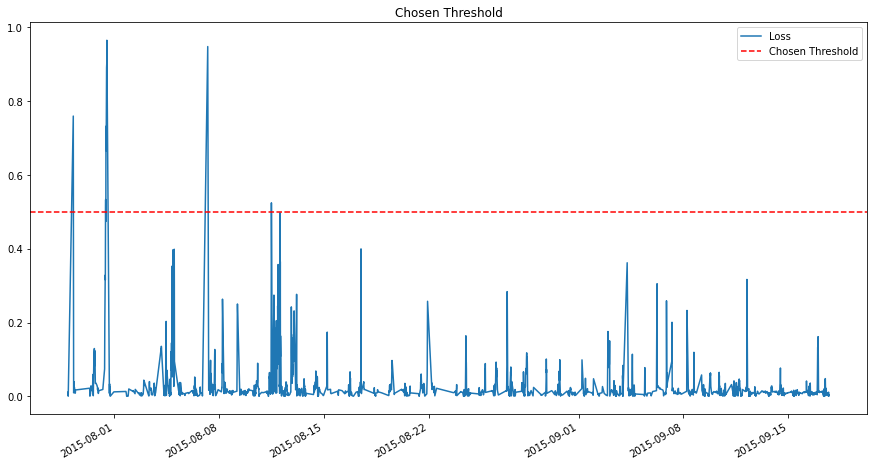

Anomalies Detected: 


2015-07-29 06:49:00    0.759585
2015-07-31 10:29:00    0.504894
2015-07-31 10:39:00    0.533254
2015-07-31 10:59:00    0.509283
2015-07-31 11:09:00    0.731919
2015-07-31 11:29:00    0.665691
2015-07-31 11:39:00    0.734755
2015-07-31 11:59:00    0.815328
2015-07-31 12:09:00    0.890414
2015-07-31 12:29:00    0.904424
2015-07-31 12:33:00    0.965008
2015-08-07 06:09:00    0.947923
2015-08-11 12:07:00    0.524375
dtype: float32

In [11]:
loss_plot(preds_losses, THRESHOLD)

print('Anomalies Detected: ')
preds_losses.loc[lambda x: x > THRESHOLD]

## Showing Anomalies in Context

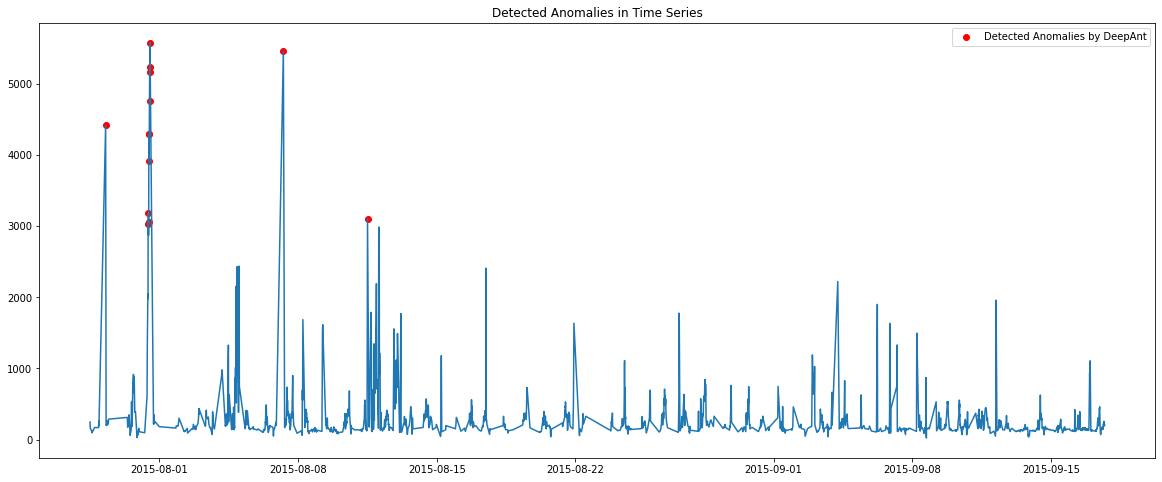

In [12]:
ts_plot(df, preds_losses, THRESHOLD)

## Looking Closer

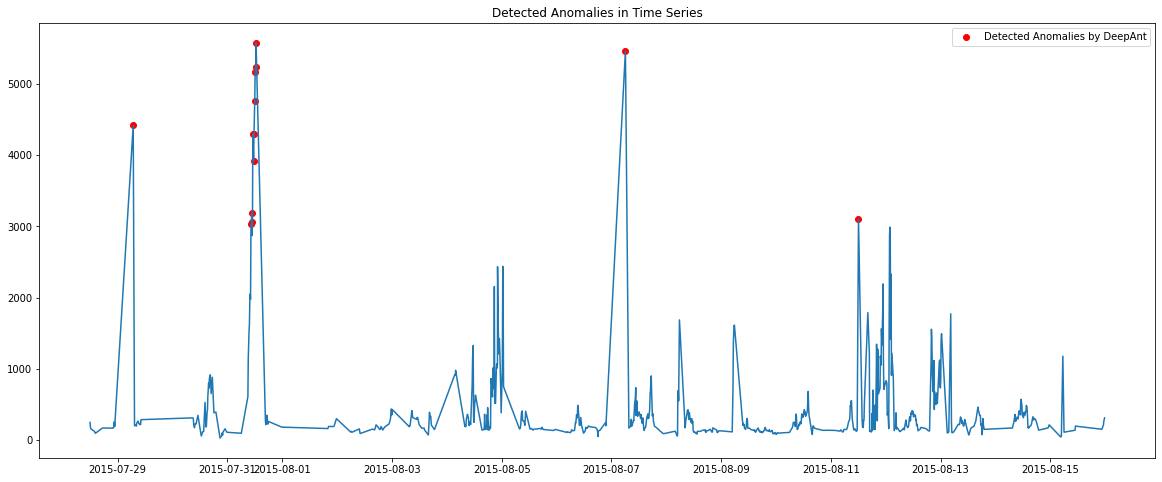

In [13]:
ts_plot(df, preds_losses, THRESHOLD, range = ('2015-07-28', '2015-08-15'))